In [1]:
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [2]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

## Preprocessing

In [3]:
sample_info = pd.read_csv('../data/sample_info.csv')
radiosensitivity = pd.read_csv('../data/radiosensitivity.csv')
expression = pd.read_csv('../data/expressionData.csv')

In [4]:
sample_info.primary_disease.value_counts()

primary_disease
Lung Cancer                   272
Leukemia                      137
Skin Cancer                   119
Lymphoma                      110
Brain Cancer                  106
Non-Cancerous                 103
Colon/Colorectal Cancer        85
Breast Cancer                  83
Head and Neck Cancer           79
Bone Cancer                    79
Ovarian Cancer                 73
Pancreatic Cancer              60
Kidney Cancer                  55
Gastric Cancer                 48
Neuroblastoma                  47
Sarcoma                        44
Endometrial/Uterine Cancer     40
Bladder Cancer                 39
Esophageal Cancer              38
Bile Duct Cancer               36
Myeloma                        35
Liver Cancer                   27
Cervical Cancer                24
Thyroid Cancer                 21
Rhabdoid                       20
Prostate Cancer                13
Unknown                        13
Eye Cancer                     11
Liposarcoma                    1

In [5]:
data = pd.merge(sample_info[['cell_line_name', 'primary_disease']], radiosensitivity[['cell_line_name', 'SF2']], on='cell_line_name', how='inner')
data.primary_disease.value_counts()

primary_disease
Lung Cancer                   98
Ovarian Cancer                36
Colon/Colorectal Cancer       35
Brain Cancer                  31
Skin Cancer                   30
Breast Cancer                 27
Pancreatic Cancer             26
Head and Neck Cancer          23
Esophageal Cancer             23
Endometrial/Uterine Cancer    21
Liver Cancer                  19
Gastric Cancer                16
Bladder Cancer                16
Kidney Cancer                 14
Sarcoma                        9
Bone Cancer                    9
Thyroid Cancer                 7
Neuroblastoma                  7
Bile Duct Cancer               4
Non-Cancerous                  4
Prostate Cancer                2
Rhabdoid                       2
Unknown                        1
Gallbladder Cancer             1
Name: count, dtype: int64

### Assigning classes to the label

In [6]:
sc = StandardScaler()
data['sf2_scaled'] = sc.fit_transform(np.asarray(data['SF2']).reshape(-1,1))

std = data['sf2_scaled'].std()
mean = data['sf2_scaled'].mean()

for i in range(data.shape[0]):
    if data.at[i, 'sf2_scaled'] < mean - std * 0.8:
        data.at[i, 'Sensitivity'] = 'sensitive'
    elif data.at[i, 'sf2_scaled'] > mean + std * 0.8:
        data.at[i, 'Sensitivity'] = 'resistant'
    else:
        data.at[i, 'Sensitivity'] = 'intermediate'

In [7]:
data.drop(columns=['SF2', 'sf2_scaled'], inplace=True)
data.head()

,cell_line_name,primary_disease,Sensitivity
0,Hs 895.T,Non-Cancerous,intermediate
1,TE 617.T,Sarcoma,sensitive
2,TE 125.T,Non-Cancerous,intermediate
3,Panc 05.04,Pancreatic Cancer,intermediate
4,JHUEM-3,Endometrial/Uterine Cancer,resistant


In [8]:
data = pd.merge(data, expression, on='cell_line_name', how='inner')

In [9]:
data.shape

(461, 19224)

In [10]:
data.groupby('Sensitivity').primary_disease.value_counts().sort_values(ascending=False)

Sensitivity   primary_disease        
intermediate  Lung Cancer                60
resistant     Lung Cancer                22
intermediate  Ovarian Cancer             20
              Brain Cancer               20
              Colon/Colorectal Cancer    18
                                         ..
resistant     Gallbladder Cancer          1
              Bone Cancer                 1
intermediate  Neuroblastoma               1
              Prostate Cancer             1
sensitive     Thyroid Cancer              1
Name: count, Length: 61, dtype: int64

In [11]:
data = data.drop(data[data.Sensitivity == 'intermediate'].index)
data.groupby('primary_disease').Sensitivity.value_counts().sort_values(ascending=False)

primary_disease             Sensitivity
Lung Cancer                 resistant      22
                            sensitive      16
Endometrial/Uterine Cancer  sensitive      13
Colon/Colorectal Cancer     sensitive      11
Ovarian Cancer              sensitive      10
Brain Cancer                resistant       9
Skin Cancer                 resistant       9
Breast Cancer               resistant       9
Pancreatic Cancer           resistant       7
Head and Neck Cancer        resistant       6
Colon/Colorectal Cancer     resistant       6
Ovarian Cancer              resistant       6
Neuroblastoma               sensitive       5
Liver Cancer                resistant       5
Esophageal Cancer           resistant       5
Bladder Cancer              resistant       4
Head and Neck Cancer        sensitive       4
Kidney Cancer               sensitive       4
Sarcoma                     sensitive       4
Skin Cancer                 sensitive       4
Bone Cancer                 sensitive   

In [12]:
data = data.drop(data[data.primary_disease != 'Lung Cancer'].index)
data.head(None)

,cell_line_name,primary_disease,Sensitivity,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),...,H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),ELOA3B (728929),NPBWR1 (2831),ELOA3D (100506888),ELOA3 (162699),CDR1 (1038)
13,JL-1,Lung Cancer,resistant,1.480265,0.000000,5.994580,1.443607,2.620586,0.014355,3.307429,...,0.321928,0.344828,0.000000,1.922198,0.000000,0.000000,0.028569,0.000000,0.000000,0.056584
20,NCI-H322,Lung Cancer,resistant,4.341986,0.000000,6.642124,2.715893,4.401221,0.070389,2.849999,...,1.416840,0.084064,0.475085,1.035624,0.298658,0.000000,0.201634,0.594549,0.124328,0.000000
35,NCI-H1650,Lung Cancer,sensitive,4.326250,0.028569,7.379638,2.289834,3.778209,0.111031,0.367371,...,1.070389,0.948601,0.310340,1.275007,0.226509,0.084064,0.356144,0.000000,0.124328,0.084064
42,RERF-LC-MS,Lung Cancer,resistant,4.105175,0.000000,5.931210,2.526069,3.758090,0.084064,5.039138,...,3.595742,0.097611,0.678072,2.620586,0.475085,0.000000,0.765535,0.124328,0.000000,0.000000
111,RERF-LC-AI,Lung Cancer,sensitive,3.805292,0.028569,6.825658,2.639232,4.594549,0.042644,0.669027,...,0.831877,0.622930,0.604071,2.847997,0.263034,0.000000,0.028569,0.992768,0.000000,0.613532
132,NCI-H2122,Lung Cancer,sensitive,3.629939,0.000000,6.394548,1.831877,3.463361,0.028569,5.009437,...,0.956057,0.000000,0.545968,1.521051,0.097611,0.014355,0.084064,0.014355,0.014355,0.000000
141,NCI-H1395,Lung Cancer,resistant,3.337711,0.000000,5.927185,1.944858,2.678072,0.014355,3.089159,...,1.090853,0.956057,0.286881,1.327687,0.000000,0.124328,0.176323,0.000000,0.084064,0.238787
158,NCI-H1781,Lung Cancer,sensitive,5.187847,0.000000,6.714520,3.476382,4.565597,0.028569,5.363171,...,1.007196,1.157044,0.584963,1.560715,0.000000,0.014355,0.310340,0.000000,0.014355,0.250962
162,LUDLU-1,Lung Cancer,resistant,4.980939,0.000000,6.506843,3.017922,4.112700,0.070389,3.909773,...,1.664483,0.000000,0.238787,2.403268,0.000000,0.000000,0.855990,0.056584,0.000000,0.000000
164,Calu-3,Lung Cancer,sensitive,5.060912,0.000000,6.475733,2.715893,3.755956,0.028569,3.303050,...,0.704872,0.604071,0.214125,0.925999,0.000000,0.000000,0.713696,0.000000,0.000000,0.000000


In [13]:
data['Sensitivity'] = data['Sensitivity'].replace({'sensitive': 1, 'resistant': 0, 'intermediate': 2})
y = data['Sensitivity']
X = data.drop(columns=['Sensitivity', 'cell_line_name', 'primary_disease'])

/scratch/tmp.32618.fschindele/ipykernel_2507222/4085223229.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Sensitivity'] = data['Sensitivity'].replace({'sensitive': 1, 'resistant': 0, 'intermediate': 2})


### LR, PCA, 5-fold CV

In [14]:
cv = KFold(n_splits = len(y))
fold = 1

train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'ROC AUC': []}
test_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'ROC AUC': []}
best_params = {'pca__n_components': [],
               'logistic__C': []}

param_grid = {'pca__n_components': np.linspace(1, 29, 10, dtype=int),
              'logistic__C': 10**np.linspace(2, -4, 10)}

y_true=[]
y_pred=[]
y_pred_proba=[]

for train_index, test_index in cv.split(X, y):
       print(f"Working on fold {fold}")
       
       X_train, X_test = X.iloc[train_index], X.iloc[test_index]
       y_train, y_test = y.iloc[train_index], y.iloc[test_index]

       pipe = Pipeline([('scaler', StandardScaler()),
                        ('pca', PCA(random_state=0)),
                        ('logistic', LogisticRegression(penalty='l1', random_state=0, solver='liblinear'))])
       search = GridSearchCV(pipe, 
                             param_grid, 
                             n_jobs=-1
                             , error_score='raise'
                             )
       clf = search.fit(X_train, y_train)

       for param in search.best_params_.keys():
              best_params[param].append(search.best_params_[param])

       y_true.append(y_test)
       y_pred.append(clf.predict(X_test))
       y_pred_proba.append(clf.decision_function(X_test))

       fold += 1

Working on fold 1


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, in

Working on fold 2


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 3


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 4


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 5


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 6


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 7


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 8


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 9


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, in

Working on fold 10


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 11


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, in

Working on fold 12


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 13


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 14


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 15


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 16


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 17


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 18


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 19


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, in

Working on fold 20


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 21


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 22


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 23


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 24


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, in

Working on fold 25


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, in

Working on fold 26


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 27


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 28


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, in

Working on fold 29


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, in

Working on fold 30


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 31


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, in

Working on fold 32


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 33
Working on fold 34


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 35


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, in

Working on fold 36


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 37


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Working on fold 38


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [15]:
best_params = pd.DataFrame(data=best_params, index=range(1,fold))
best_params

,pca__n_components,logistic__C
1,1,100.000000
2,1,100.000000
3,1,100.000000
4,1,100.000000
5,1,100.000000
6,1,100.000000
7,1,100.000000
8,1,100.000000
9,1,100.000000
10,1,21.544347


In [16]:
def evaluation(y_true, y_pred, y_pred_proba):
    fp_rates, tp_rates, _ = roc_curve(y, y_pred_proba)
    roc_auc = auc(fp_rates, tp_rates)

    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)
    roc_auc   = auc(fp_rates, tp_rates)
    confusion = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, roc_auc, fp_rates, tp_rates, confusion

In [17]:
accuracy, precision, recall, f1, roc_auc, fp_rates, tp_rates, confusion = evaluation(y_true, y_pred, y_pred_proba)

In [18]:
confusion

array([[18,  4],
       [ 8,  8]])

In [19]:
print(f"Performance all {fold} folds:")
print(f"Accuracy = {accuracy:.4f}\nPrecision = {precision:.4f}\nRecall = {recall:.4f}\nF1 = {f1:.4f}\nROC AUC = {roc_auc:.4f}")

Performance all 39 folds:
Accuracy = 0.6842
Precision = 0.6667
Recall = 0.5000
F1 = 0.5714
ROC AUC = 0.6250


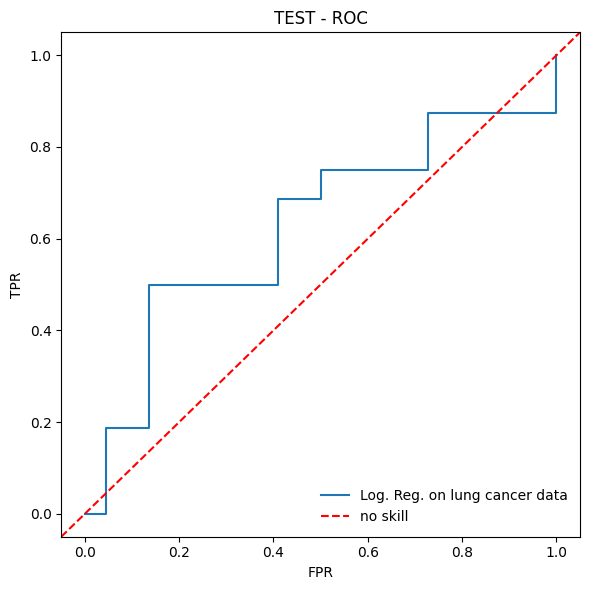

In [20]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(fp_rates, tp_rates, label='Log. Reg. on lung cancer data')

ax.set(title= 'TEST - ROC',
       xlabel = 'FPR',
       ylabel ='TPR')
add_identity(ax, color="r", ls="--", label = 'no skill')
ax.legend(frameon=False, loc='lower right')
plt.tight_layout()
plt.savefig('../output/LR_lungcancer_ROC.pdf')
plt.show()

### Performance
Most folds chose n_components = 1, C = 100
| Metric     | Value   |
|------------|---------|
| Accuracy   | 0.6842  |
| Precision  | 0.6667  |
| Recall     | 0.5000  |
| F1         | 0.5714  |
| ROC AUC    | 0.6250  |

Reducing paramter grid to at least 2 for n_components leads to same behaviour. Most folds choose 2 PCs to include into the model. C still very often 100. 
| Metric     | Value   |
|------------|---------|
| Accuracy   | 0.6316  |
| Precision  | 0.6000  |
| Recall     | 0.3750  |
| F1         | 0.4615  |
| ROC AUC    | 0.6051  |
